<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/issue/troubleshooting01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install

In [15]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt

Cloning into 'c620'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 1091 (delta 173), reused 95 (delta 42), pack-reused 807
Receiving objects: 100% (1091/1091), 30.01 MiB | 24.82 MiB/s, done.
Resolving deltas: 100% (711/711), done.


# import 

In [16]:
from c620.F import F
from c620.config import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# demo data

In [17]:
tag = 'test001'
demo = joblib.load('./data/demo.pkl')
print(demo.keys())

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c620_wt', 'c660_op', 'c660_wt', 'c670_op', 'c670_wt'])


In [18]:
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']

In [19]:
icg_input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
124-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,72.0,0.0911,20.854397,74.689774,70.0,980.0,0.01,9.999955,36.0


# 問題 : 模型不管什麼給輸入 輸出結果都一樣

In [20]:
f = F(config)
f.Recommended_mode = False #(True or False)
f.real_data_mode = False
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,178.120468,194.412445


In [21]:
f = F(config)
f.Recommended_mode = True #(True or False)
f.real_data_mode = False
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

current Distillate Rate_m3/hr:0.4746916636938635 NA in Benzene_ppmw:980.0


,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,178.120468,194.434647


一種可能的原因是上面那一組樣本的問題
* 1.NA in Benzene_ppmw = 980.0 
* 2.Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt% = 70 

恰巧等於推薦模式下的初始值,造成推薦模式並沒有做額外的工作

# 解法

嘗試修改輸入樣本

In [22]:
icg_input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] = 980*2
icg_input['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'] = 70*2
icg_input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
124-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,72.0,0.0911,20.854397,74.689774,140,1960,0.01,9.999955,36.0


In [23]:
f = F(config)
f.Recommended_mode = False #(True or False)
f.real_data_mode = False
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,178.11998,194.744385


In [24]:
f = F(config)
f.Recommended_mode = True #(True or False)
f.real_data_mode = False
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

current Distillate Rate_m3/hr:0.4746916636938635 NA in Benzene_ppmw:980.0


,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,178.120468,194.434647


成功了 Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC 數值有變動

# 觀察 改動 icg_input 如何影響 c620_wt and c620_op 

In [25]:
f = F(config)
f.Recommended_mode = False
f.real_data_mode = False
icg_input = demo['icg_input']
logger = {}
from tqdm import tqdm_notebook as tqdm
for c in tqdm(icg_input.columns):
  logger[c] = {}
  init_value = icg_input[c].values[0]
  for m in tqdm(np.arange(0.5,2.0,0.1)):
    icg_input[c] = init_value*m # change input
    c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed) # get output
    logger[c][init_value*m] = c620_wt.join(c620_op) # record

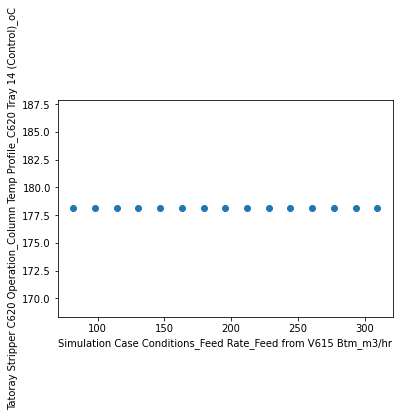

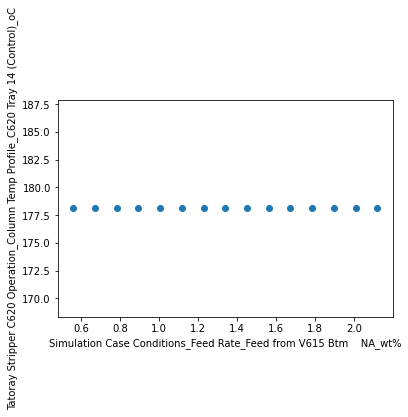

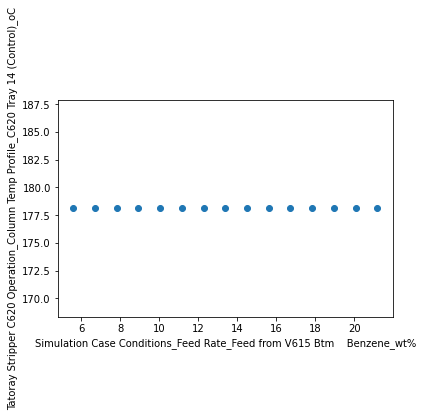

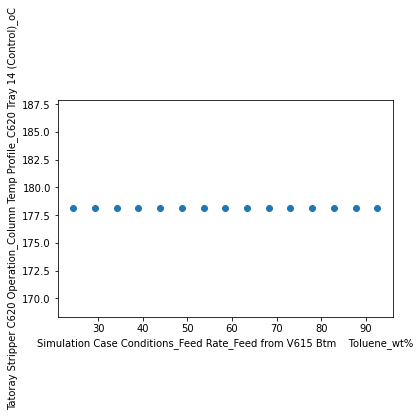

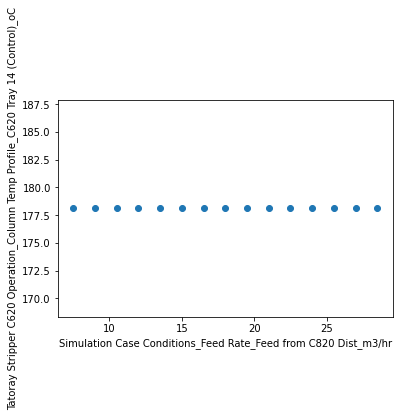

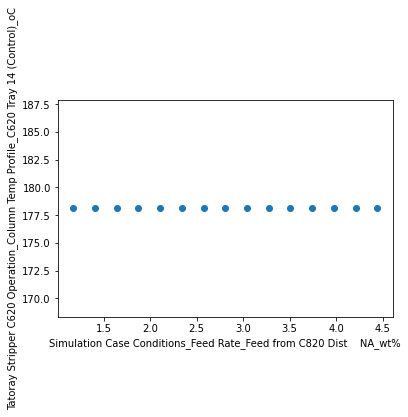

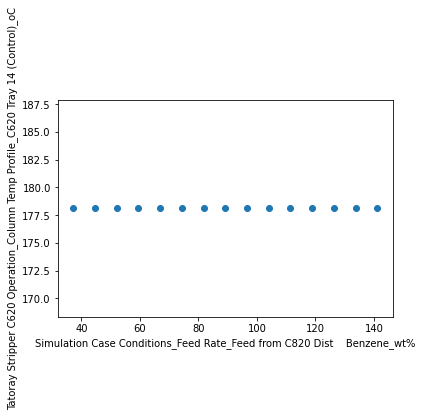

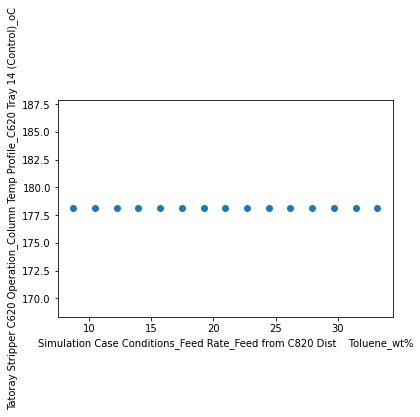

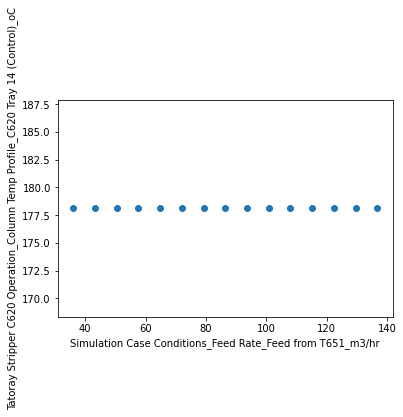

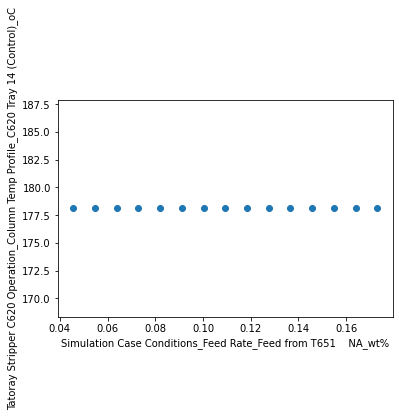

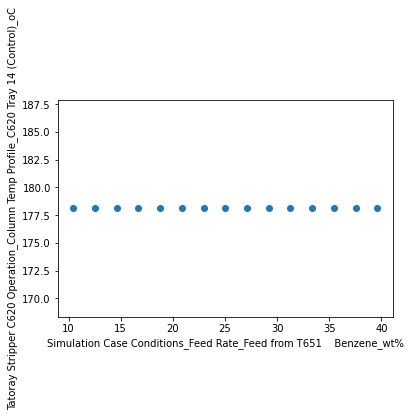

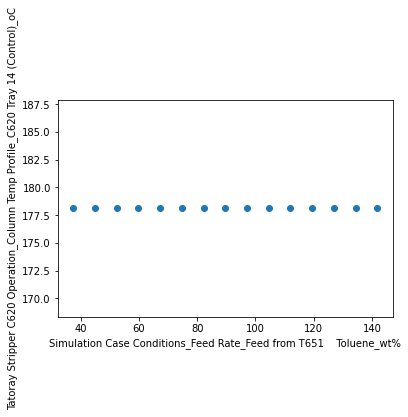

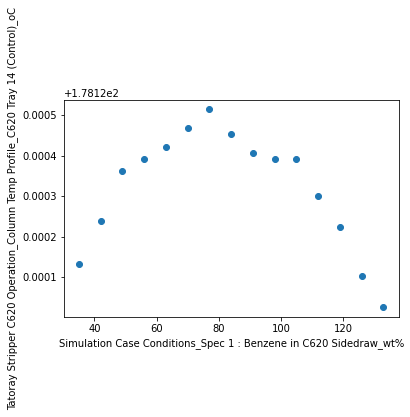

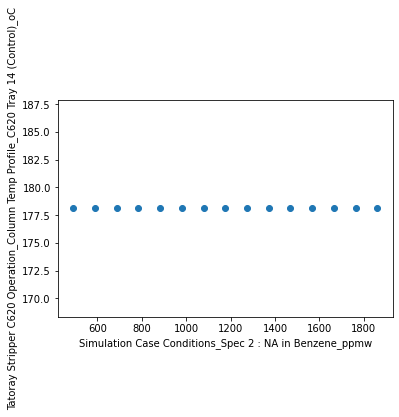

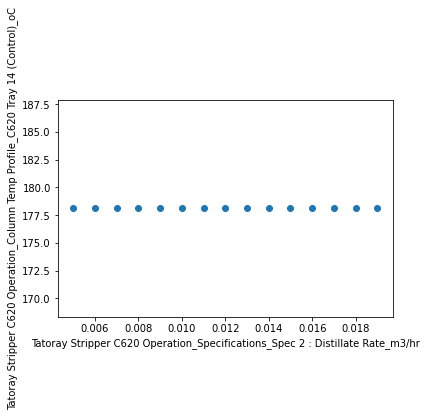

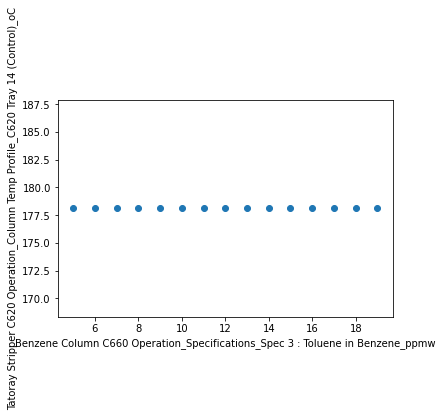

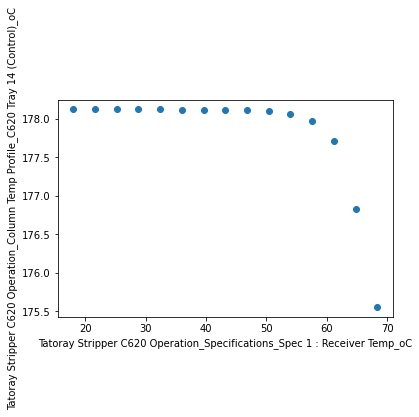

In [26]:
import matplotlib.pyplot as plt

for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')
  plt.show()

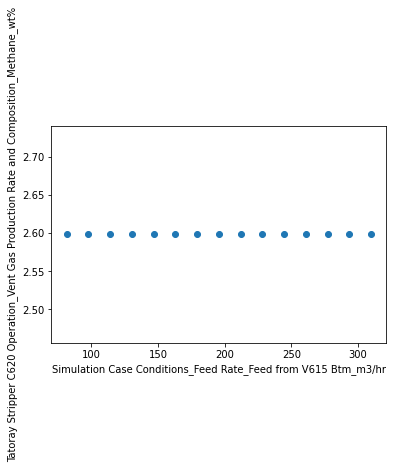

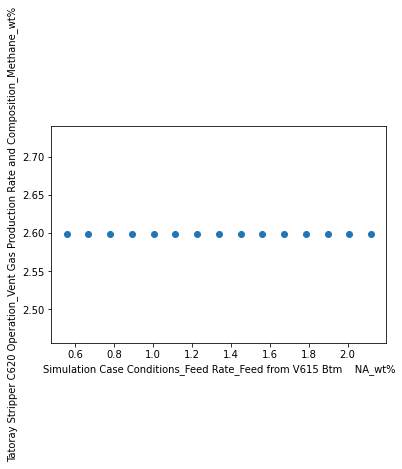

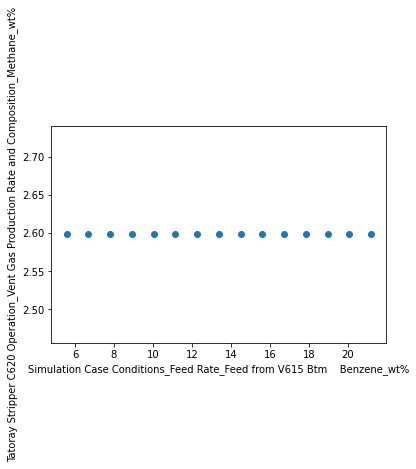

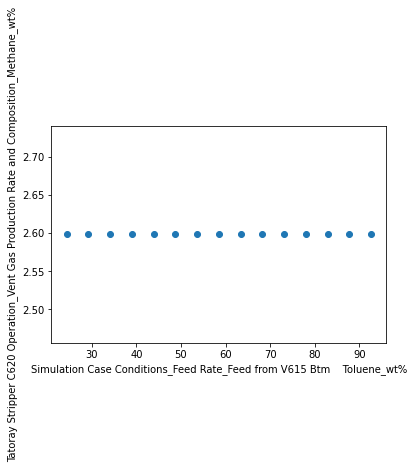

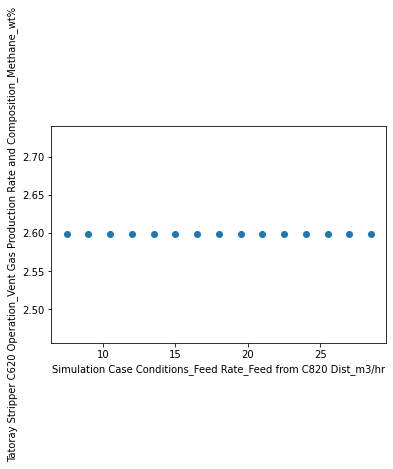

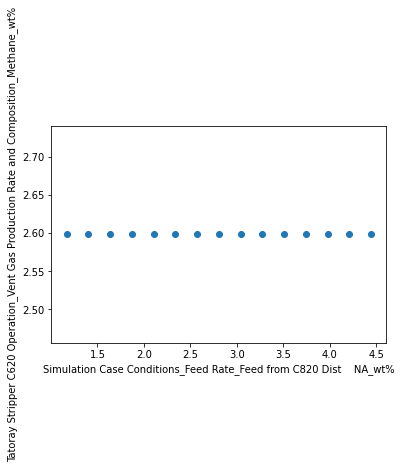

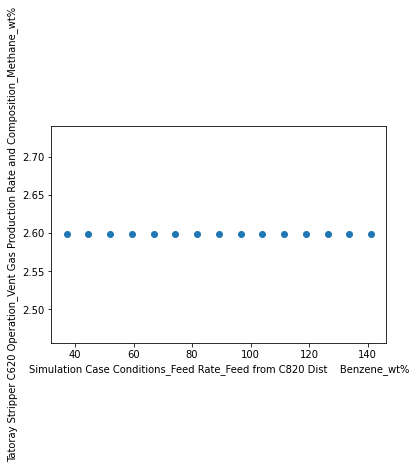

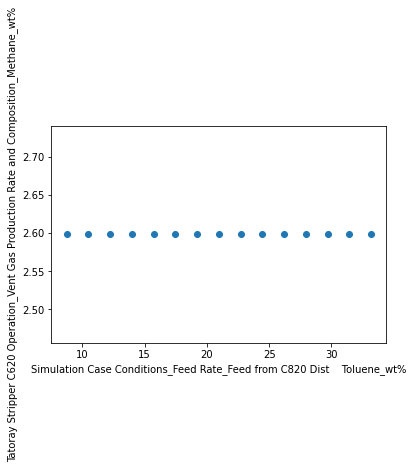

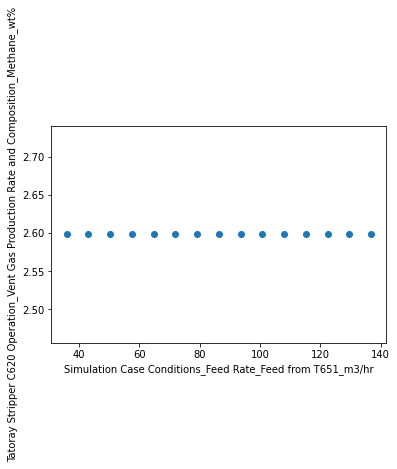

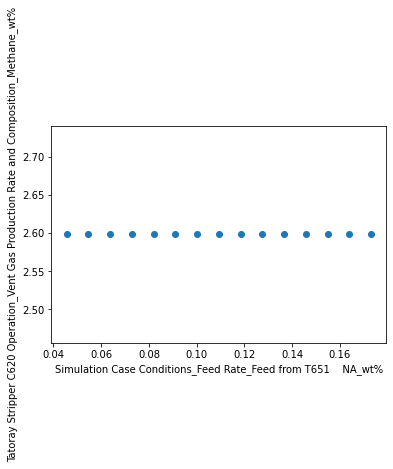

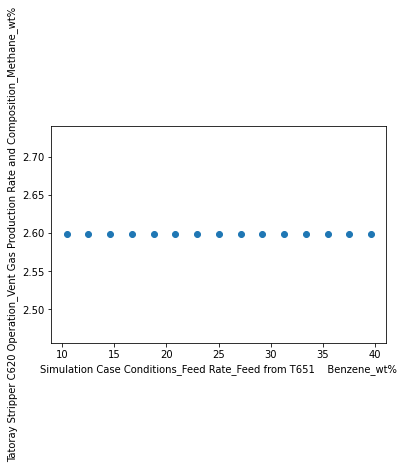

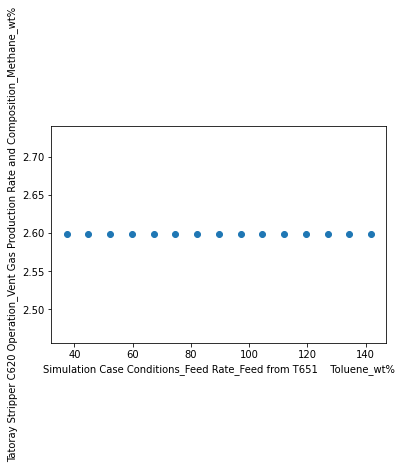

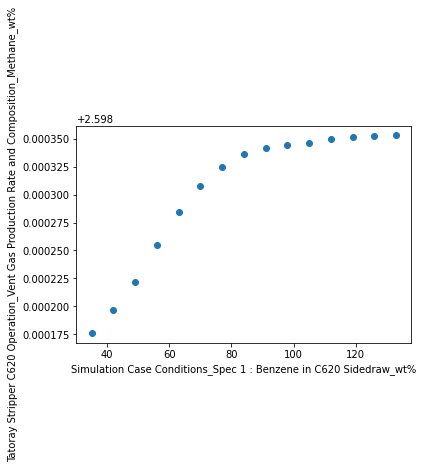

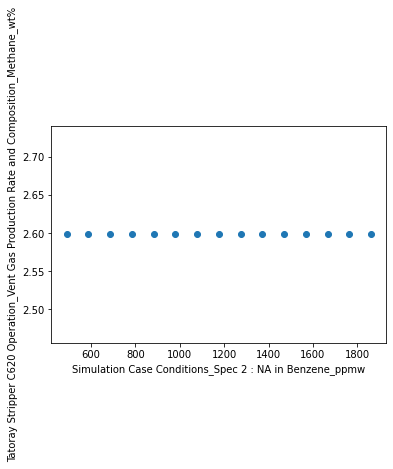

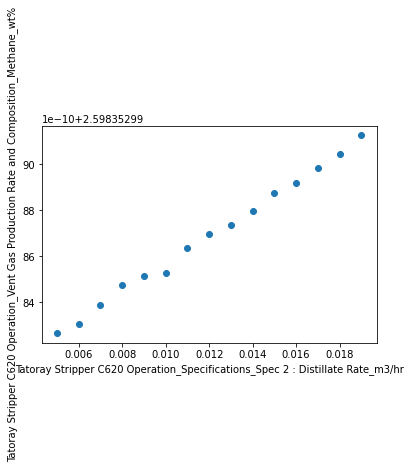

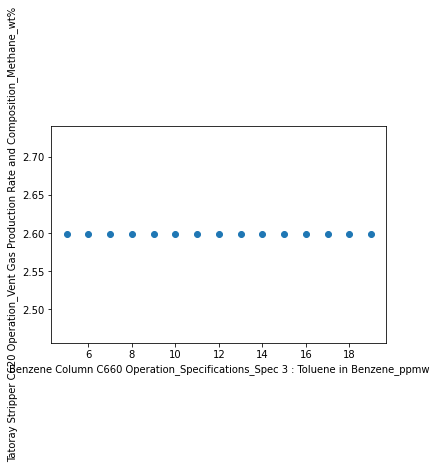

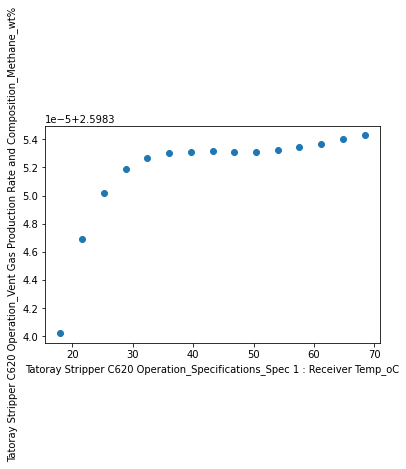

In [27]:
for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%')
  plt.show()

* 觀察得出在 "模擬模式" 下 調整icg_input 某些值 確實會對 c620_wt and c620_op 造成影響 沒毛病

# 以下使用一樣的模擬數據來做一樣的實驗但是改成 "現場模式"

In [28]:
f = F(config)
f.Recommended_mode = False
f.real_data_mode = True #改成現場模式
icg_input = demo['icg_input']
logger = {}
from tqdm import tqdm_notebook as tqdm
for c in tqdm(icg_input.columns):
  logger[c] = {}
  init_value = icg_input[c].values[0]
  for m in tqdm(np.arange(0.5,2.0,0.1)):
    icg_input[c] = init_value*m # change input
    c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed) # get output
    logger[c][init_value*m] = c620_wt.join(c620_op) # record

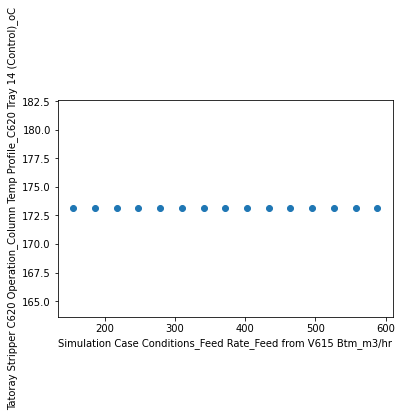

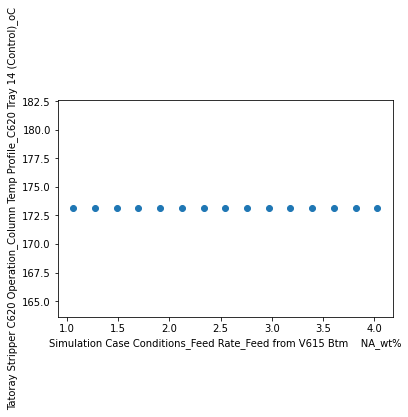

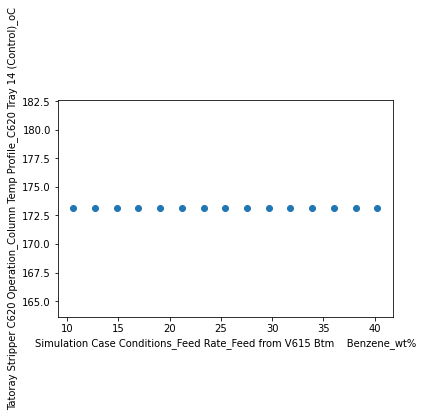

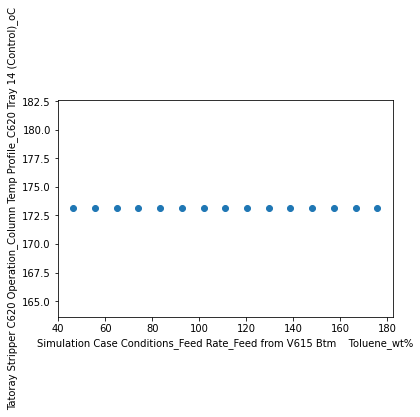

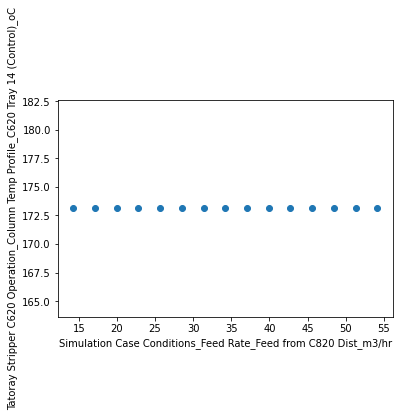

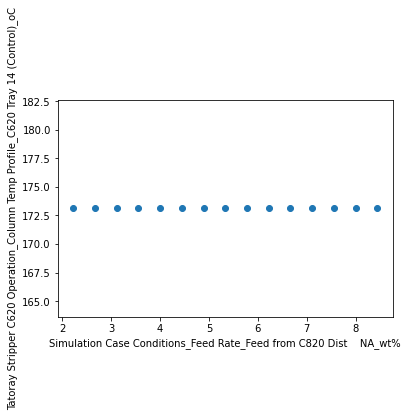

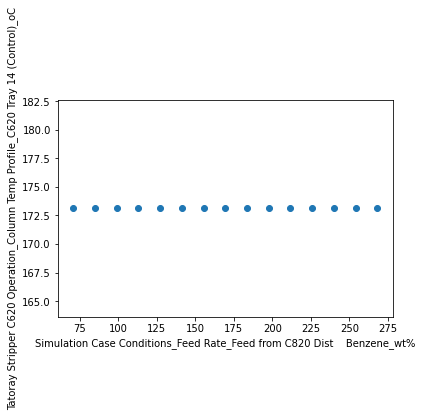

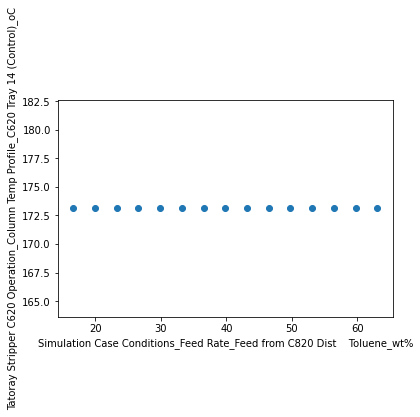

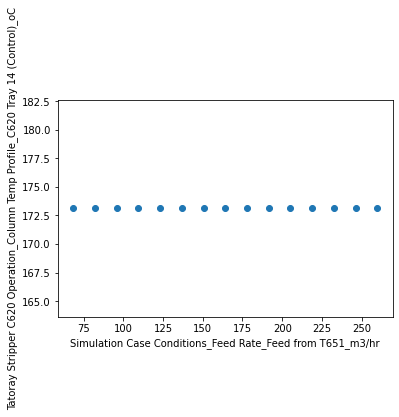

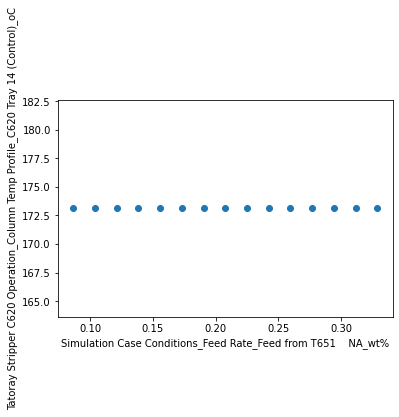

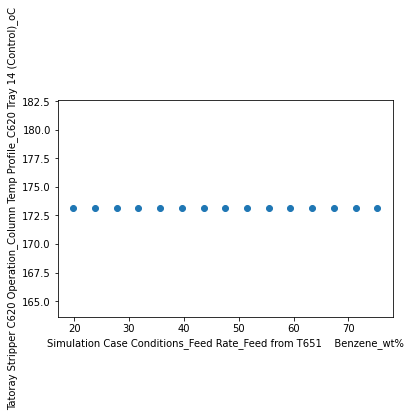

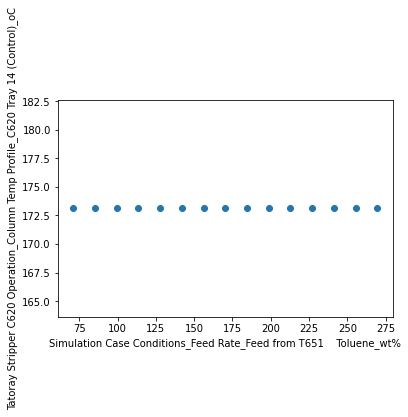

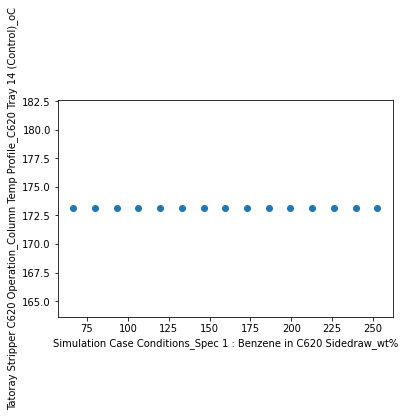

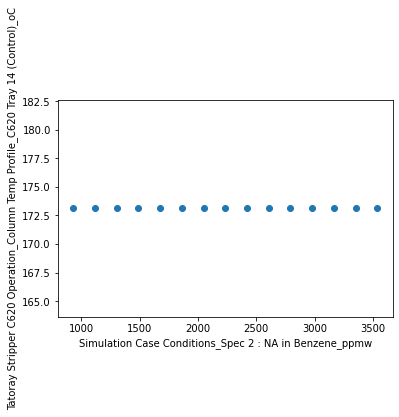

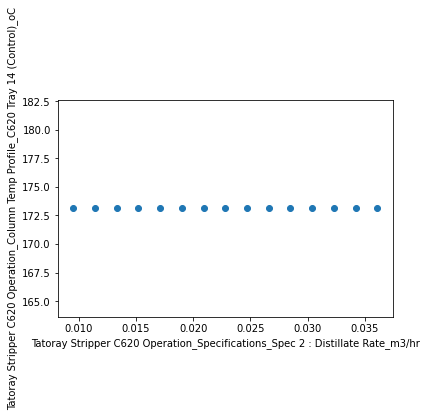

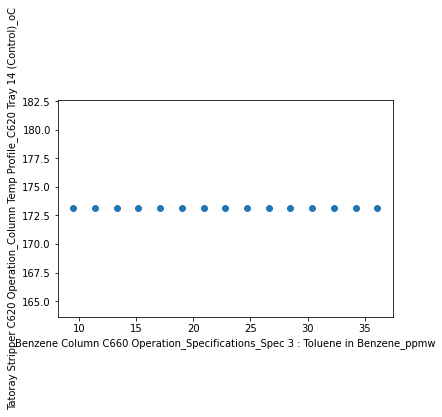

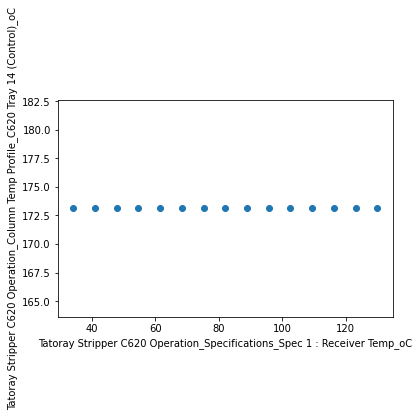

In [29]:
for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')
  plt.show()

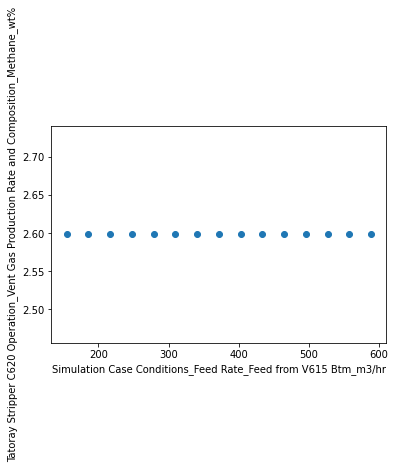

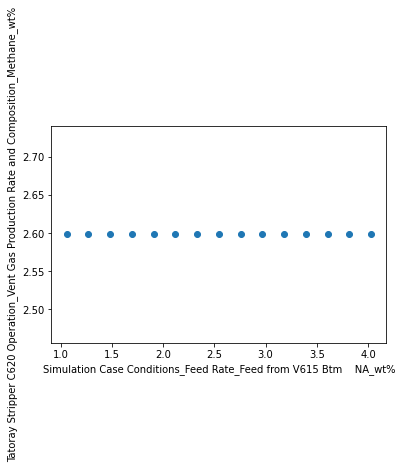

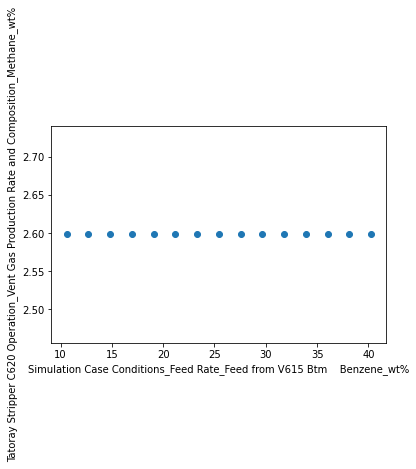

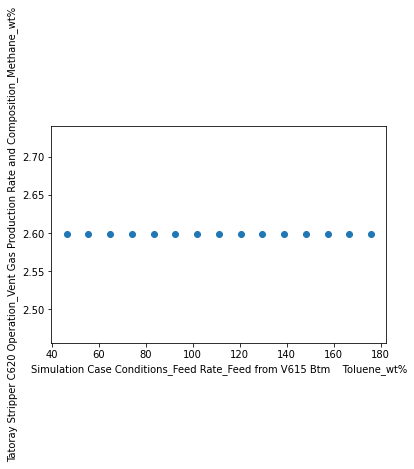

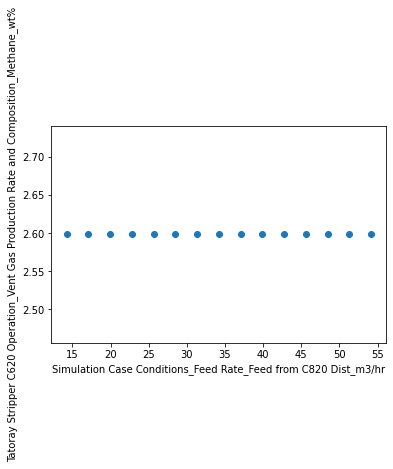

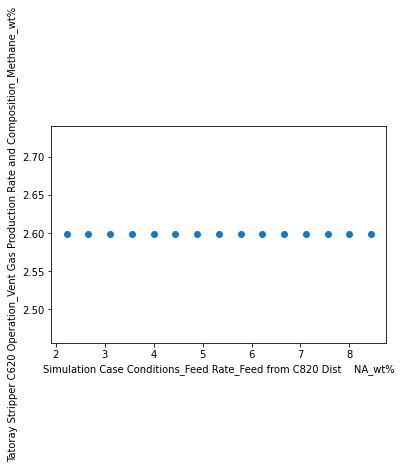

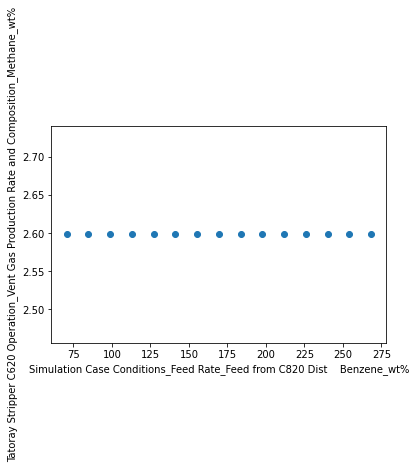

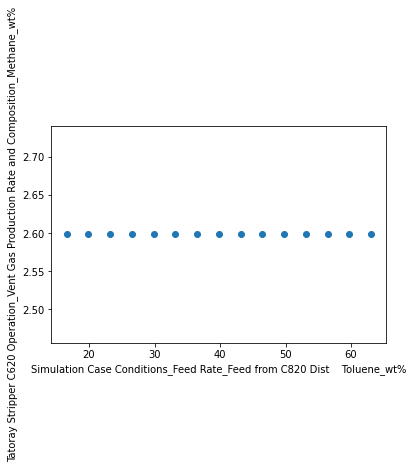

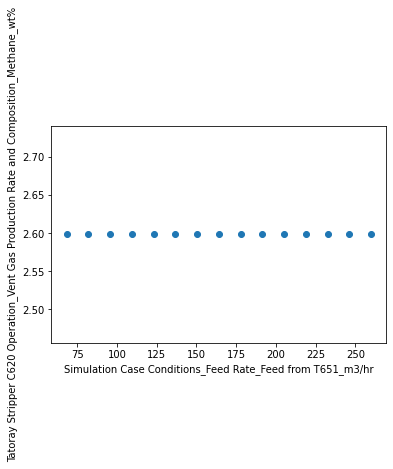

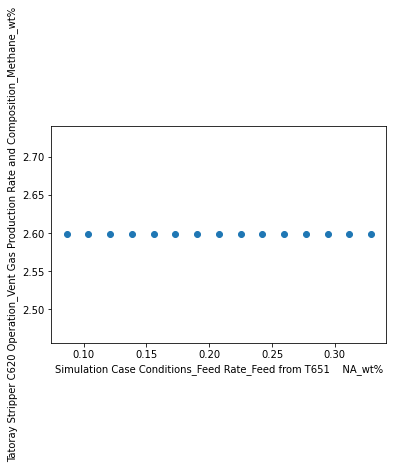

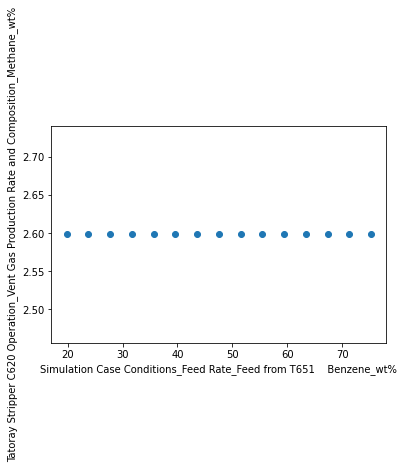

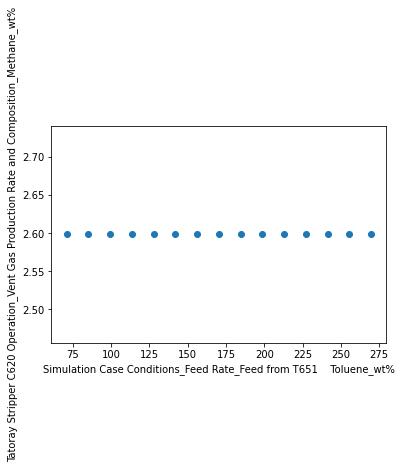

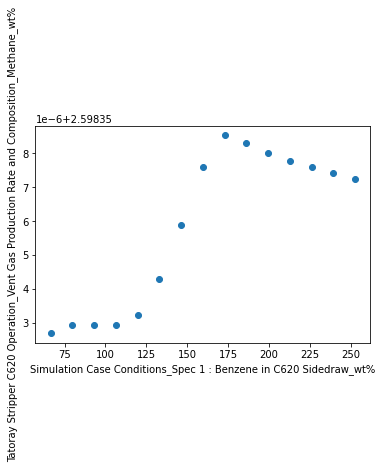

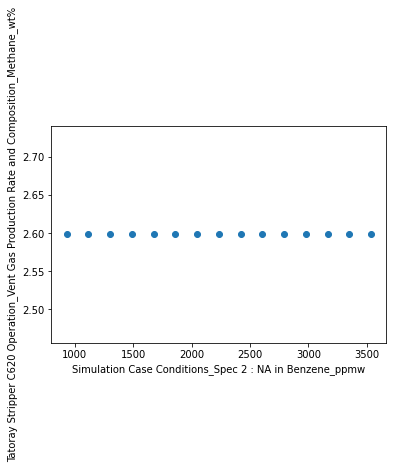

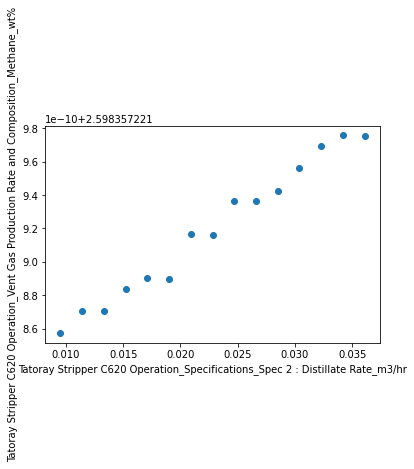

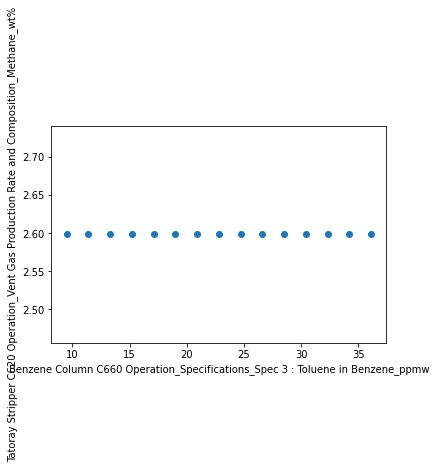

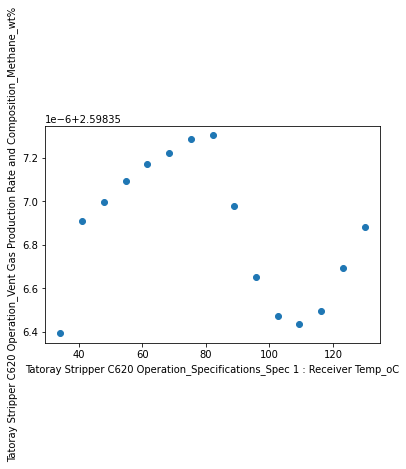

In [30]:
for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%')
  plt.show()

* 觀察得出不管如何調整icg_input c620_op 都是固定在一個值
* 個人懷疑一種可能是因為限制y的值域的緣故,實際數據的y可能最多就是173左右,173是上界

# 想法驗證

In [40]:
f.c620_real_data_model.y_col.index('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')

6

In [41]:
f.c620_real_data_model.ss_y.data_max_[6]

173.1294845205

# 賓果

因此得出結論 

* 1.模擬數據 只能用在模擬模式 模擬數據如果用在真實模式就會出問題
* 2.目前跟業主索取更完整的真實數據,實驗在真實模式下使用真實數據